In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
temp_data_train = pd.read_csv('../Data/train_data.csv')
temp_data_test = pd.read_csv('../Data/test_data.csv')
# Convert the 'date' column to datetime
temp_data_train['date'] = pd.to_datetime(temp_data_train['date'])
temp_data_test['date'] = pd.to_datetime(temp_data_test['date'])

T_actual_train = temp_data_train['mean'].to_numpy()
T_actual_test = temp_data_test['mean'].to_numpy()

temp_data_test.head()

,date,mean,max,min
0,2024-04-01,10.33,20.39,3.61
1,2024-04-02,13.22,24.22,4.50
2,2024-04-03,14.72,24.39,3.72
3,2024-04-04,12.28,24.22,5.11
4,2024-04-05,8.22,16.89,3.50


Linear and Seasonal forecast

In [3]:
# Forecast horizon
forecast_end = 365

# Create empty DataFrame with placeholders
forecast_df = pd.DataFrame(index=np.arange(forecast_end), columns=['date', 't', 'trend', 'seasonal', 'forecast', 'actual'])

# Assign actual values (truncate if necessary)
forecast_df['actual'] = T_actual_test[:forecast_end]

# Set date range starting from first test date
start_date = temp_data_test['date'].iloc[0]
date_range = pd.date_range(start=start_date, periods=forecast_end)
forecast_df['date'] = date_range

# Set time index t continuing from training period
start_t = len(temp_data_train)  # assuming daily data with t = 0,1,...,N
forecast_df['t'] = np.arange(start_t + 1, start_t + forecast_end + 1)

# Dummy trend model (replace with real coefficients)
intercept, slope = 16.72181, 0.00002
forecast_df['trend'] =  intercept + slope * forecast_df['t']

# View the first few rows
print(forecast_df.head())

        date      t     trend seasonal forecast  actual
0 2024-04-01  33287  17.38755      NaN      NaN   10.33
1 2024-04-02  33288  17.38757      NaN      NaN   13.22
2 2024-04-03  33289  17.38759      NaN      NaN   14.72
3 2024-04-04  33290  17.38761      NaN      NaN   12.28
4 2024-04-05  33291  17.38763      NaN      NaN    8.22


In [4]:
def forecast_seasonal(t_future, fitted_params):
    """
    Forecast seasonal component using fitted sinusoidal model
    
    Parameters:
    t_future: array-like, future time points to forecast
    fitted_params: list or array containing [a1, phi1, a2, phi2, a3, phi3, a4, phi4]
    
    Returns:
    array of forecasted seasonal values
    """
    a1, phi1, a2, phi2, a3, phi3, a4, phi4 = fitted_params
    p1, p2, p3 = 365, 730, 1460
    p4 = 2920  # ~8 years modulation period
    
    # Calculate each component
    cycle1 = a1 * np.sin(2 * np.pi * (t_future - phi1) / p1)
    cycle2 = a2 * np.sin(2 * np.pi * (t_future - phi2) / p2)
    cycle3 = a3 * np.sin(2 * np.pi * (t_future - phi3) / p3)
    modulated = a4 * (1 + np.sin(2 * np.pi * (t_future - phi4) / p4)) * np.sin(2 * np.pi * t_future / 365)
    
    return cycle1 + cycle2 + cycle3 + modulated

t_future = np.arange(start_t + 1, start_t + forecast_end + 1)

# Your fitted parameters from the model
fitted_params = [6.222, 44.85,    # a1, phi1
                0.640, 206.55,    # a2, phi2
                0.977, 2119.84,   # a3, phi3
                -0.2277, 423.1776]         # Add your fitted a4, phi4 values

# Generate forecast
seasonal_forecast = forecast_seasonal(t_future, fitted_params)
# Add seasonal forecast to the forecast dataframe
forecast_df['seasonal'] = seasonal_forecast[:forecast_end]

In [5]:
def forecast_sigmaboy(t_future, fitted_params):
    """
    Forecast seasonal variance using fitted sinusoidal model
    
    Parameters:
    t_future: array-like, future time points to forecast
    fitted_params: list or array containing [a1, phi1, a2, phi2, a3, phi3, a4, phi4]
    
    Returns:
    array of forecasted seasonal values
    """
    c0, a1, b1, a2, b2, a3, b3, a4, b4 = fitted_params
    
    # Calculate each component
    return (c0 + a1 * np.cos(2 * np.pi * 1 * t_future / 365) + b1 * np.sin(2 * np.pi * 1 * t_future / 365) +
          a2 * np.cos(2 * np.pi * 2 * t_future / 365) + b2 * np.sin(2 * np.pi * 2 * t_future / 365) +
          a3 * np.cos(2 * np.pi * 3 * t_future / 365) + b3 * np.sin(2 * np.pi * 3 * t_future / 365) +
          a4 * np.cos(2 * np.pi * 4 * t_future / 365) + b4 * np.sin(2 * np.pi * 4 * t_future / 365))

figa = forecast_df['date'].iloc[0].dayofyear
t_future = np.arange(figa, figa + forecast_end + 1)

# Your fitted parameters from the model
fitted_params = [12.3412, -0.0129,                  # c0, a1
                -0.7476, -0.7740,                   # b1, a2
                -1.0577, 1.0056,                    # b2, a3
                0.7967, -0.2421, -0.6885]           # b3, a4, b4

# Generate forecast
sigmaboy = forecast_sigmaboy(t_future, fitted_params)
# Add seasonal forecast to the forecast dataframe
forecast_df['sigmaboy'] = sigmaboy[:forecast_end]

Mean Absolute Error (MAE): 4.637473961148339
Mean Squared Error (MSE): 31.76620373190843
Root Mean Squared Error (RMSE): 5.636151500084826
Correlation Coefficient: 0.5497924312217832


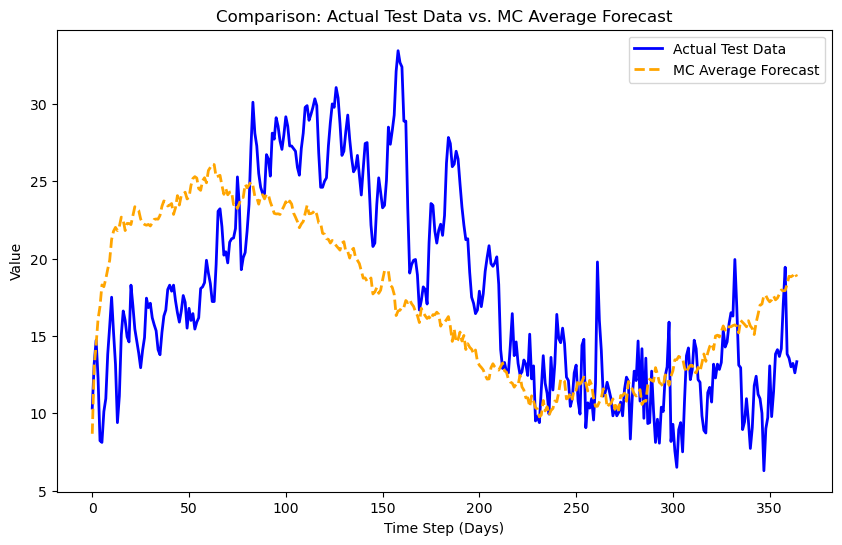

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

k = -0.1571                           # Fixed speed of mean reversion (a scalar)

n_paths = 1000     # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    previous_value = T_all[:, t-1]
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = forecast_df['trend'].iloc[t-1] + forecast_df['seasonal'].iloc[t-1] + (1 + k) * (previous_value - forecast_df['seasonal'].iloc[t-2] - forecast_df['trend'].iloc[t-2]) + forecast_df['sigmaboy'].iloc[t-1] * eps

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()

Mean Absolute Error (MAE): 1.4950677057864359
Mean Squared Error (MSE): 3.763530558799998
Root Mean Squared Error (RMSE): 1.9399821027009496
Correlation Coefficient: 0.956740525901703


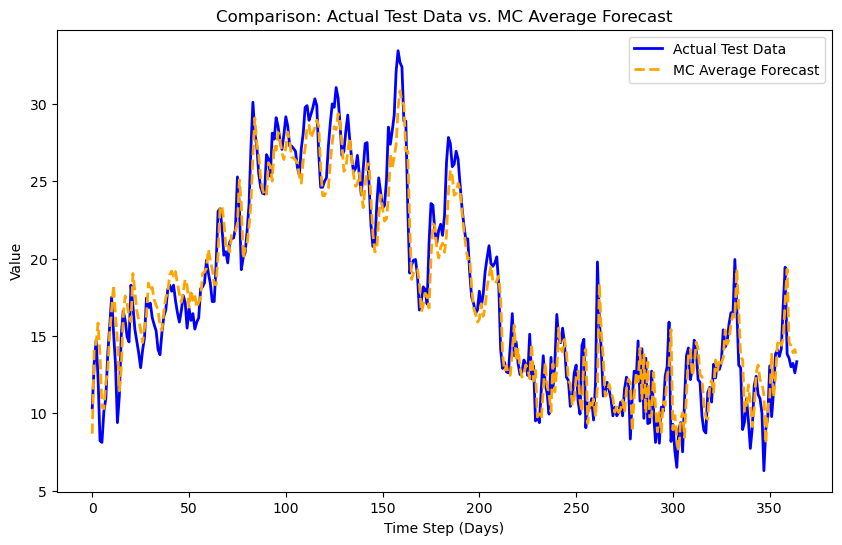

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

k = -0.1571                           # Fixed speed of mean reversion (a scalar)

n_paths = 1000000     # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    # Use the actual observed data at t-1 if available, otherwise fall back on the simulation
    if t-1 < len(T_actual_test):
        previous_value = T_actual_test[t-1]
    else:
        # If actual data is not available (e.g., beyond the test sample), you may use the forecasted average:
        previous_value = np.mean(T_all[:, t-1])
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = forecast_df['trend'].iloc[t-1] + forecast_df['seasonal'].iloc[t-1] + (1 + k) * (previous_value - forecast_df['seasonal'].iloc[t-2] - forecast_df['trend'].iloc[t-2]) + forecast_df['sigmaboy'].iloc[t-1] * eps

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()